# Convolutional Neural Networks


### What is it?

A **convolutional neural network (CNN)** is a type of deep neural network that excels at learning **spatial structure** in data (e.g., images, video). Instead of connecting every input pixel to every (hidden) neuron, CNNs learn **local filters** (i.e., kernels) that detects patterns such as edges, textures, and objects.

The idea: **reuse parameters** through shared kernels to drastically cut model size while automating feature extraction.

---

### How It Works

Conceptual pipeline:

1. **Convolution**: apply $K$ learnable filters (e.g. $3\times3$) that slide across the input, producing $K$ *feature maps*.
2. **Activation**: pass feature maps through a nonlinear function (e.g. ReLU).
3. **Pooling**: down‑sample spatial resolution (e.g. max‑pool) to make representations more compact and invariant to small translations.
4. **Stack & Repeat**: **deeper** layers look at *features‑of‑features*, forming a hierarchy from edges $\rightarrow$ motifs → parts → whole objects.
5. **Flatten & Dense**: collapse spatial dimensions and feed into one or more *fully‑connected* layers (e.g., MLP) for final prediction 


### Pros and Cons

✅ **Automatic feature learning**—no handcrafted filters needed.  
✅ **Parameter sharing** keeps models efficient relative to fully‑connected networks.  
✅ **Strong performance** on grid‑structured data (images, speech spectrograms, etc.)  
✅ **Translation invariance** via convolution + pooling makes recognition robust.  

❌ Can be **data‑hungry**—large networks need many labeled examples.  
❌ **Computationally intensive**; training deep CNNs may require GPUs.  
❌ Sensitive to **hyper‑parameters** (kernel size, strides, learning rate, etc.).  
❌ Fully connected classifier head still loses some spatial information.  

---

### Key Hyper‑parameters 

| Symbol in `torch/keras` | Meaning | Typical starter value |
| ----------------------- | ------- | --------------------- |
| `kernel_size`           | width/height of convolution filter | 3 or 5 |
| `filters` / `out_channels` | number of feature maps | 32 → 64 → 128 |
| `stride`                | step size of kernel | 1 (convolution), 2 (downsampling) |
| `padding`               | zeros added around input to control output size | `"same"` or 1 |
| `pool_size`             | size of pooling window | 2 |
| `dropout_rate`          | fraction of activations dropped | 0.2 – 0.5 |

---

## Load Data and Downsample

In [7]:
import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import numpy as np
import random

# -------------------- 1.  Reproducibility -----------------------------------
seed = 42
torch.manual_seed(seed);  np.random.seed(seed);  random.seed(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -------------------- 2.  Data transforms -----------------------------------
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

full_train = datasets.MNIST(root="data", train=True,  download=True, transform=transform)
test_ds     = datasets.MNIST(root="data", train=False, download=True, transform=transform)

# -------------------- 3.  Down-sample train set by 10× ----------------------
fraction = 0.10                       # keep 10 %
n_total  = len(full_train)            # 60 000
n_keep   = int(n_total * fraction)    # 6 000

indices  = np.random.permutation(n_total)[:n_keep]  # pick without replacement
train_ds = Subset(full_train, indices)

print(f"Using {len(train_ds)} / {n_total} training images.")

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=1000)

Using 6000 / 60000 training images.


## Visualize the Digits

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def show_pixel_matrix(img):
    """
    Display a 28×28 numeric matrix of gray-scale values alongside the image.

    Parameters
    ----------
    img : torch.Tensor  shape [1, 28, 28] or [28, 28] – *NOT* normalized
                       (values 0‒1 or 0‒255 are both OK)
    """
    # ---- 1. squeeze & convert to numpy ------------------------
    if img.dim() == 3:               # [1,H,W] → [H,W]
        img_2d = img.squeeze(0)
    else:                            # already [H,W]
        img_2d = img
    arr = img_2d.cpu().numpy()

    # ---- 2. if values are in 0‒1, scale to 0‒255 -------------
    if arr.max() <= 1.0:
        arr = (arr * 255).round()

    # ---- 3. visualise ----------------------------------------
    fig, ax = plt.subplots(figsize=(6,6))
    ax.imshow(arr, cmap="gray")
    ax.set_xticks(range(28))
    ax.set_yticks(range(28))
    ax.set_xticklabels(range(28), fontsize=6)
    ax.set_yticklabels(range(28), fontsize=6)
    ax.set_xlabel("Pixel column (x)", fontsize=10)
    ax.set_ylabel("Pixel row (y)", fontsize=10)
    ax.set_title("Grayscale value at each pixel", fontsize=12)

    # Annotate every cell with its value
    for (y, x), val in np.ndenumerate(arr):
        ax.text(x, y, f"{int(val):3}", va='center', ha='center',
                color="red" if val < 128 else "blue", fontsize=5)

    plt.tight_layout()
    plt.show()


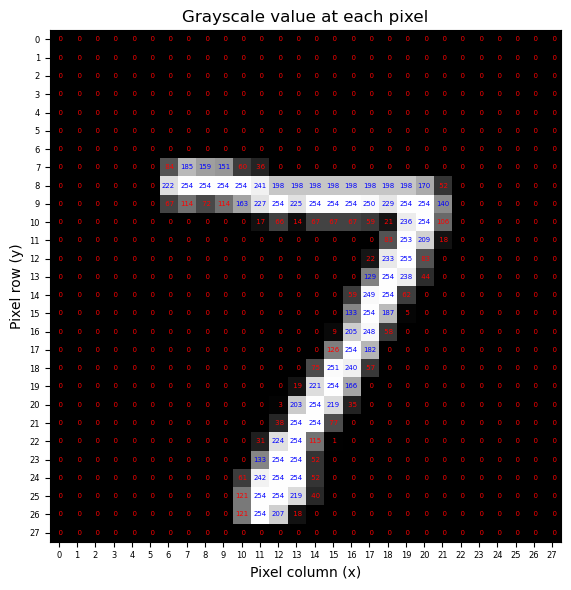

In [9]:
img_tensor, _ = test_ds[0]          # if coming from DataLoader
img_tensor = (img_tensor * 0.3081 + 0.1307)  # <-- UN-normalize if needed
show_pixel_matrix(img_tensor)

## Convolution Layer

In [10]:
import torch, torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

# ------------------------------------------------------------
# 1️⃣  Compute the 3 × 3-convolution output
# ------------------------------------------------------------
def convolve_3x3(img, kernel=None, *, undo_normalize=True):
    """
    Parameters
    ----------
    img  : torch.Tensor shape [1,28,28] or [28,28]
           *single–channel MNIST digit* (after ToTensor; may be normalized)
    kernel : iterable/np.ndarray/torch.Tensor 3×3
             defaults to a simple edge detector
    undo_normalize : bool  (if True, reverses mean=0.1307, std=0.3081)

    Returns
    -------
    torch.Tensor  shape [26,26] – the filtered image
    """
    # --- prepare image ------------------------------------------------------
    if img.dim() == 3:          # [1,H,W]  → [H,W]
        img = img.squeeze(0)
    if undo_normalize:          # bring back to 0‒1 range for intuition
        img = img * 0.3081 + 0.1307
    img4d = img.unsqueeze(0).unsqueeze(0)   # [1,1,28,28]

    # --- prepare kernel -----------------------------------------------------
    if kernel is None:          # default: Laplacian edge detector
        kernel = [[-1, -1, -1],
                  [-1,  8, -1],
                  [-1, -1, -1]]
    k = torch.tensor(kernel, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # [1,1,3,3]

    # --- 2-D convolution ----------------------------------------------------
    conv_out = F.conv2d(img4d, k, stride=1, padding=0)  # [1,1,26,26]
    return conv_out.squeeze()      # [26,26]


# ------------------------------------------------------------
# 2️⃣  Visualise a 3 × 3 kernel with numeric labels
# ------------------------------------------------------------
def show_kernel(kernel, *, cmap="gray", fontsize=14):
    """
    Display a 3×3 filter as an image with its weight values overlaid.

    Parameters
    ----------
    kernel : iterable/np.ndarray/torch.Tensor 3×3
    cmap   : str  matplotlib colormap
    """
    k = np.array(kernel, dtype=float).reshape(3, 3)
    plt.figure(figsize=(2.5, 2.5))
    plt.imshow(k, cmap=cmap, vmin=k.min(), vmax=k.max())
    plt.xticks(range(3)); plt.yticks(range(3))
    for (y, x), v in np.ndenumerate(k):
        plt.text(x, y, f"{v:+}", ha="center", va="center",
                 color="red" if v < 0 else "white",
                 fontsize=fontsize, fontweight="bold")
    plt.title("3×3 convolution kernel")
    plt.tight_layout(); plt.show()


# ------------------------------------------------------------
# 🔍  Example usage
# ------------------------------------------------------------
# img_tensor, _ = test_ds[0]                  # from your DataLoader
# output = convolve_3x3(img_tensor)           # [26,26] tensor
# show_kernel([[-1,-1,-1], [-1,8,-1], [-1,-1,-1]])
#
# plt.imshow(output, cmap="gray"); plt.title("After 3×3 convolution"); plt.show()


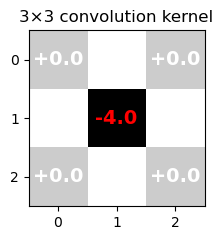

In [15]:
img_tensor, _ = test_ds[0]          # if coming from DataLoader
img_tensor = (img_tensor * 0.3081 + 0.1307)  # <-- UN-normalize if needed

filtered = convolve_3x3(img_tensor, kernel=[[0,1,0],[1,-4,1],[0,1,0]])
show_kernel([[0,1,0],[1,-4,1],[0,1,0]])

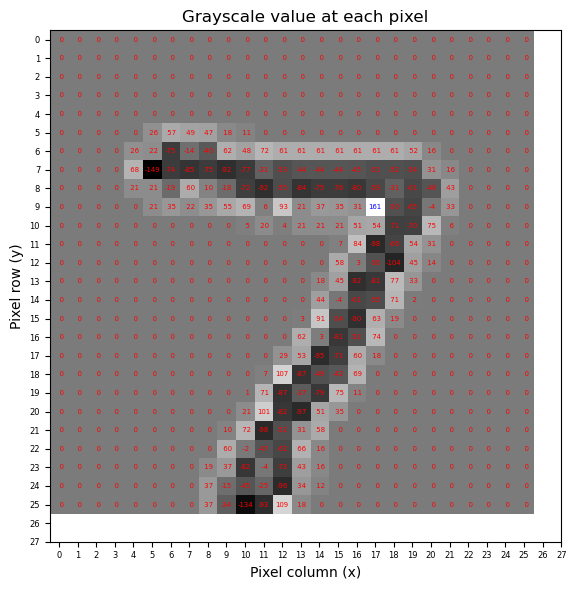

In [16]:
show_pixel_matrix(filtered)

## Modeling

In [17]:

# ---- 2. Model --------------------------------------------------------------
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),                 # 14×14
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2)                  # 7×7
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*7*7, 128), nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 10)
        )

    def forward(self, x): return self.fc(self.conv(x))

cnn = SimpleCNN().to(device)

In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr=1e-3)

train_losses = []                           

for epoch in range(1, 21):
    cnn.train()
    running_loss = 0.0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        loss = criterion(cnn(x), y)
        loss.backward(); optimizer.step()
        running_loss += loss.item() * x.size(0)

    avg_loss = running_loss / len(train_loader.dataset)
    train_losses.append(avg_loss)            # ← log it
    print(f"Epoch {epoch:2d}: loss {avg_loss:.4f}")


Epoch  1: loss 0.6950
Epoch  2: loss 0.1843
Epoch  3: loss 0.1179
Epoch  4: loss 0.0802
Epoch  5: loss 0.0617
Epoch  6: loss 0.0547
Epoch  7: loss 0.0424
Epoch  8: loss 0.0362
Epoch  9: loss 0.0335
Epoch 10: loss 0.0227
Epoch 11: loss 0.0173
Epoch 12: loss 0.0161
Epoch 13: loss 0.0166
Epoch 14: loss 0.0191
Epoch 15: loss 0.0141
Epoch 16: loss 0.0105
Epoch 17: loss 0.0116
Epoch 18: loss 0.0067
Epoch 19: loss 0.0121
Epoch 20: loss 0.0123


In [19]:

# -------------------------------------------------------------
# 2. FNN with ≈ CNN parameter count (≈ 4.2 × 10⁵)
#    Architecture: 784 → 512 → 32 → 10
# -------------------------------------------------------------
class FNN_SameParams(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 512), nn.ReLU(),
            nn.Linear(512,  32), nn.ReLU(),
            nn.Linear( 32,  10)
        )
    def forward(self, x): return self.net(x)

fnn = FNN_SameParams().to(device)

def count_params(m):
    return sum(p.numel() for p in m.parameters() if p.requires_grad)

print(f"FNN parameter count: {count_params(fnn):,}")


FNN parameter count: 418,666


In [20]:
# -------------------------------------------------------------
# 3. Train for 20 epochs & log loss
# -------------------------------------------------------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(fnn.parameters(), lr=1e-3)

train_loss_fnn = []

for epoch in range(1, 21):
    fnn.train()
    running = 0.0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        loss = criterion(fnn(x), y)
        loss.backward(); optimizer.step()
        running += loss.item() * x.size(0)
    avg = running / len(train_loader.dataset)
    train_loss_fnn.append(avg)
    print(f"Epoch {epoch:2d}/20  –  loss {avg:.4f}")


Epoch  1/20  –  loss 0.6398
Epoch  2/20  –  loss 0.2597
Epoch  3/20  –  loss 0.1670
Epoch  4/20  –  loss 0.1139
Epoch  5/20  –  loss 0.0822
Epoch  6/20  –  loss 0.0500
Epoch  7/20  –  loss 0.0328
Epoch  8/20  –  loss 0.0188
Epoch  9/20  –  loss 0.0130
Epoch 10/20  –  loss 0.0085
Epoch 11/20  –  loss 0.0048
Epoch 12/20  –  loss 0.0030
Epoch 13/20  –  loss 0.0024
Epoch 14/20  –  loss 0.0019
Epoch 15/20  –  loss 0.0016
Epoch 16/20  –  loss 0.0014
Epoch 17/20  –  loss 0.0012
Epoch 18/20  –  loss 0.0010
Epoch 19/20  –  loss 0.0009
Epoch 20/20  –  loss 0.0008


## Training loss

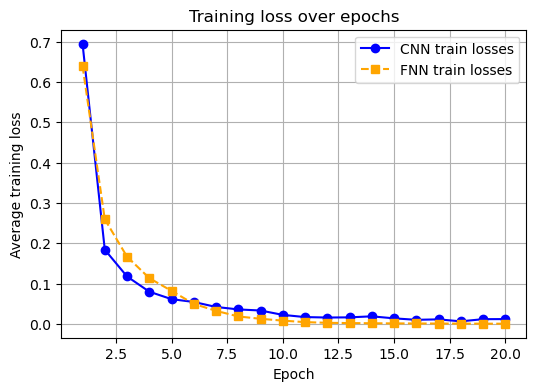

In [21]:
import matplotlib.pyplot as plt
epochs=range(1, len(train_losses)+1)
plt.figure(figsize=(6,4))
plt.plot(epochs, train_losses, marker="o",color='blue', label='CNN train losses')
# FNN curve
plt.plot(epochs, train_loss_fnn , marker="s", linestyle="--", color='orange',label="FNN train losses")
plt.xlabel("Epoch")
plt.ylabel("Average training loss")
plt.title("Training loss over epochs")
plt.legend()
plt.grid(True)
plt.show()


## Model Diagnostics

In [22]:
import numpy as np
import matplotlib.pyplot as plt

def find_misclassified(model, loader, max_items=25):
    model.eval(); mistakes = []
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            preds = model(x).argmax(1)
            wrong = preds.ne(y)
            for img, p, t in zip(x[wrong], preds[wrong], y[wrong]):
                mistakes.append((img.cpu(), int(p), int(t)))
                if len(mistakes) == max_items:
                    return mistakes
    return mistakes



In [23]:
all_mis = find_misclassified(cnn, test_loader, max_items=len(test_loader.dataset))
print(f"Misclassification rate: {len(all_mis)/1000}")
all_mis = find_misclassified(fnn, test_loader, max_items=len(test_loader.dataset))
print(f"Misclassification rate: {len(all_mis)/1000}")


Misclassification rate: 0.181
Misclassification rate: 0.466


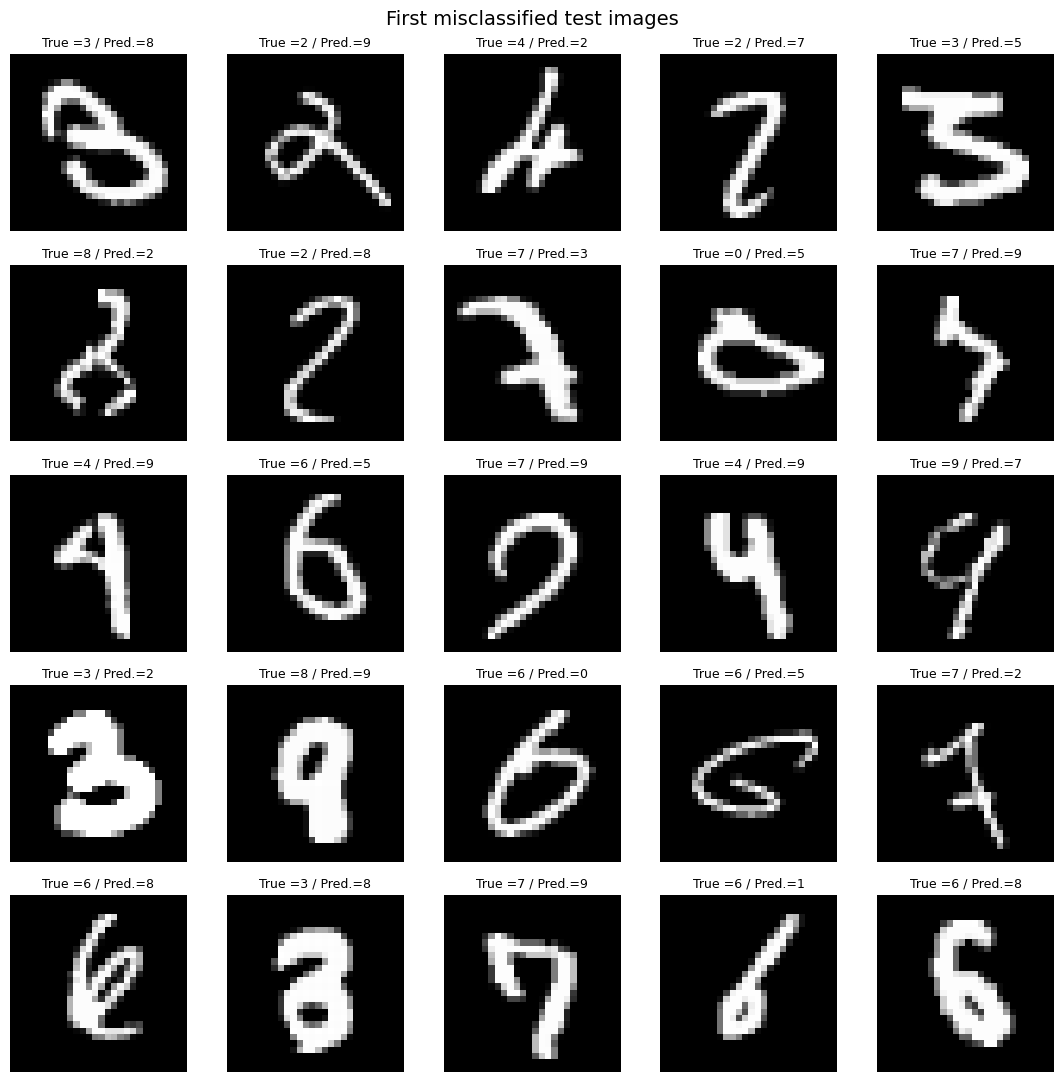

In [24]:
# --- gather mistakes for CNN

mis = find_misclassified(cnn, test_loader, max_items=25)

# --- visualize in a 5×5 grid -------------------------------------------------
cols = 5
rows = int(np.ceil(len(mis) / cols))
plt.figure(figsize=(2.2*cols, 2.2*rows))

for i, (img, pred, true) in enumerate(mis, 1):
    plt.subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(f"True ={true} / Pred.={pred}", fontsize=9)
    plt.axis("off")

plt.suptitle("First misclassified test images", fontsize=14)
plt.tight_layout()
plt.show()

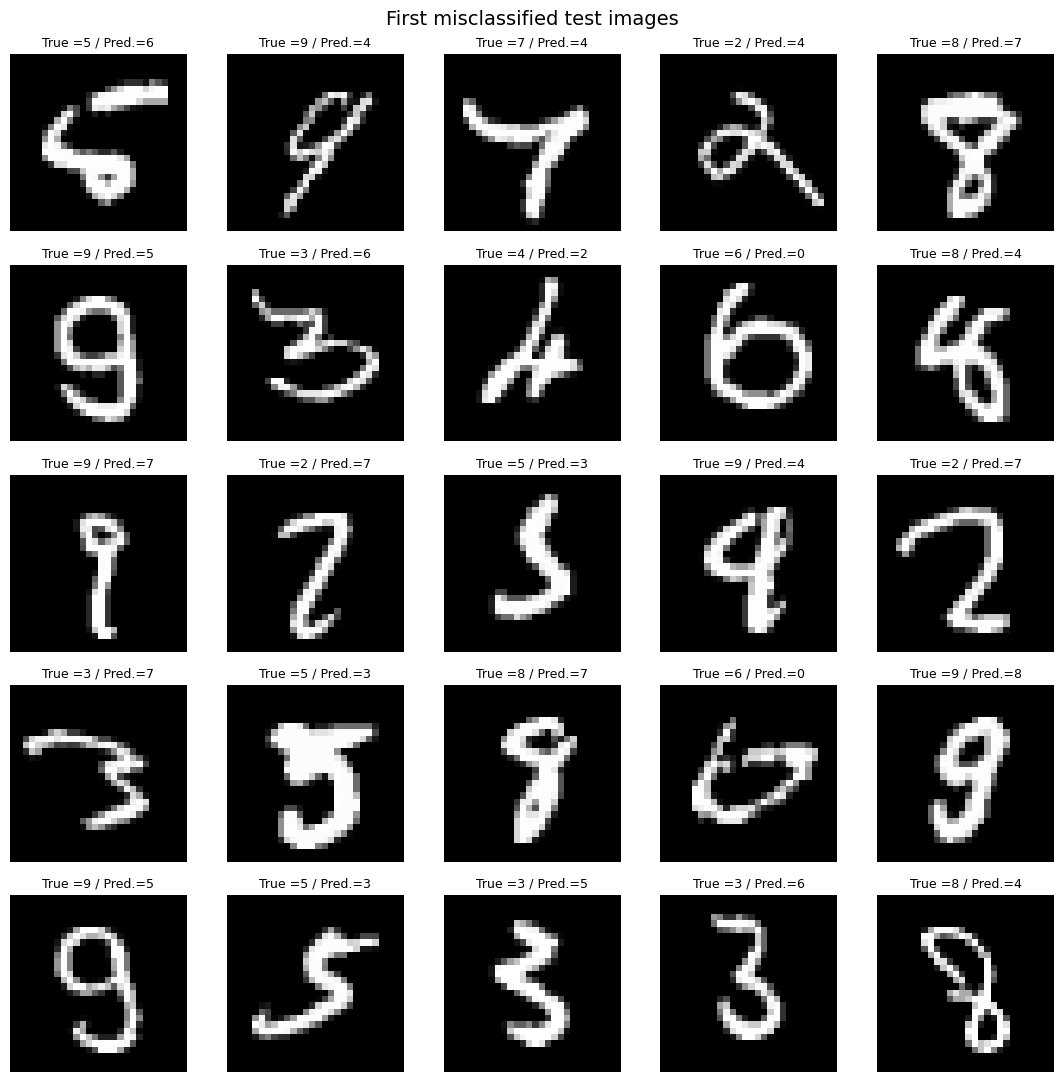

In [13]:

mis = find_misclassified(fnn, test_loader, max_items=25)

# --- visualize in a 5×5 grid -------------------------------------------------
cols = 5
rows = int(np.ceil(len(mis) / cols))
plt.figure(figsize=(2.2*cols, 2.2*rows))

for i, (img, pred, true) in enumerate(mis, 1):
    plt.subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(f"True ={true} / Pred.={pred}", fontsize=9)
    plt.axis("off")

plt.suptitle("First misclassified test images", fontsize=14)
plt.tight_layout()
plt.show()

## Checking Convolution Layers

In [25]:
import torch, torch.nn as nn
import matplotlib.pyplot as plt
import math

def show_feature_maps(model, img, layer_num=0, channel=None, title=None):
    """
    Visualise feature maps from the N-th Conv2d layer of `model`.
    
    Args
    ----
    model : torch.nn.Module           (e.g. cnn)
    img   : torch.Tensor shape [1,C,H,W]
    layer_num : int                   index of Conv2d layer (0 = first conv)
    channel   : int | None            if None → show ALL channels in a grid;
                                       else show only this channel
    title     : str | None            optional plot title
    """
    # 1️⃣  locate the desired Conv2d
    conv_layers = [m for m in model.modules() if isinstance(m, nn.Conv2d)]
    if layer_num >= len(conv_layers):
        raise ValueError(f"Model has only {len(conv_layers)} conv layers.")
    target_layer = conv_layers[layer_num]

    # 2️⃣  forward-hook to capture its output
    activations = {}
    def hook_fn(_, __, output):
        activations['feat'] = output.detach().cpu()
    handle = target_layer.register_forward_hook(hook_fn)

    # 3️⃣  run a forward pass
    model.eval()
    with torch.no_grad():
        _ = model(img.to(next(model.parameters()).device))

    handle.remove()
    fmap = activations['feat'].squeeze(0)         # shape [C, H, W]

    # 4️⃣  pick channels & plot
    if channel is not None:
        fmap = fmap[channel].unsqueeze(0)         # keep dims for loop
    n_ch   = fmap.size(0)
    cols   = min(8, n_ch)
    rows   = math.ceil(n_ch / cols)
    plt.figure(figsize=(cols*2, rows*2))
    for idx in range(n_ch):
        plt.subplot(rows, cols, idx+1)
        plt.imshow(fmap[idx], cmap='gray')
        plt.axis('off')
        plt.title(f'c{idx}', fontsize=8)
    if title:
        plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()


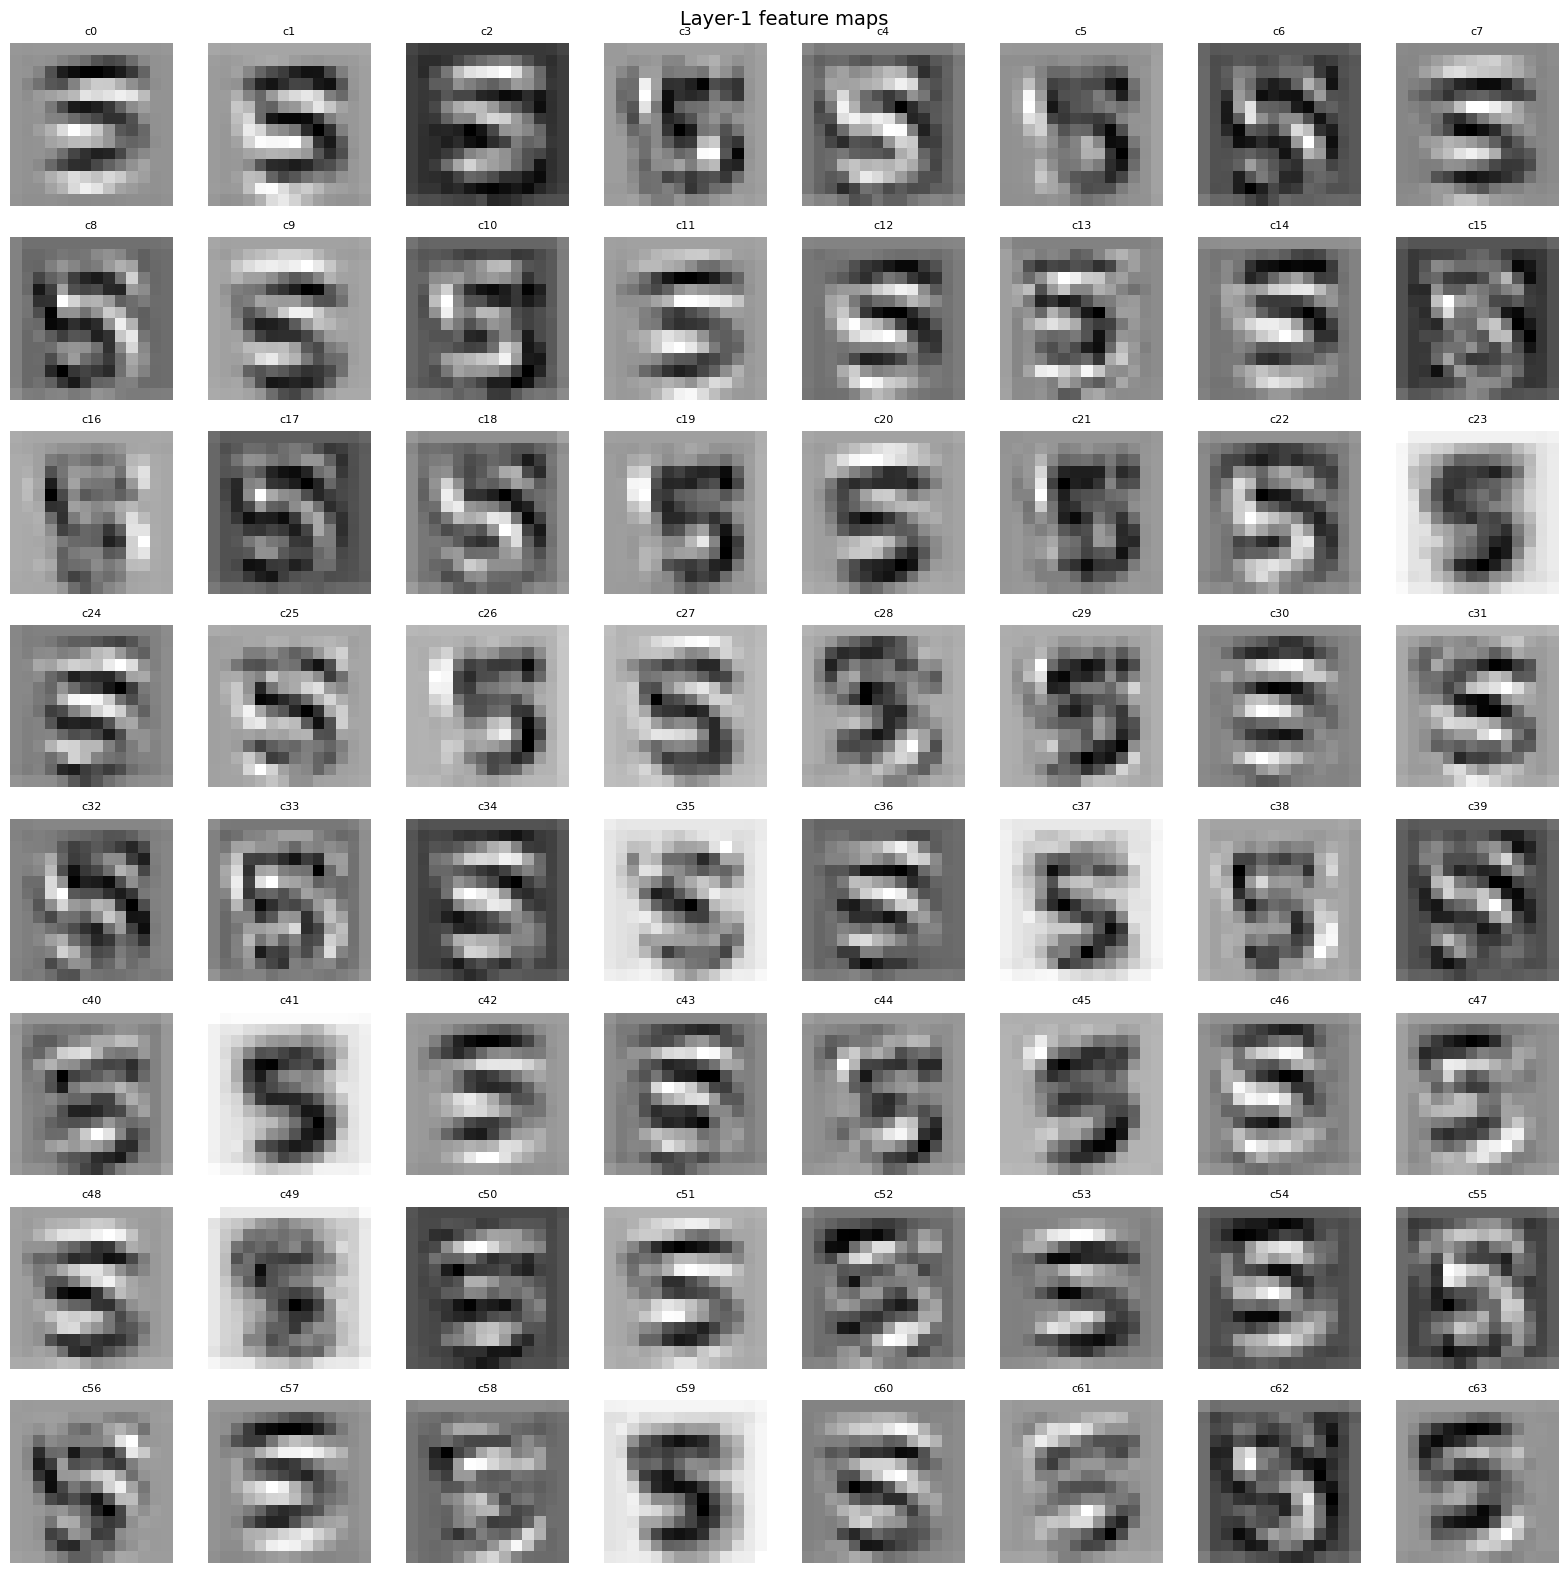

In [26]:
# (1) Grab a *raw* MNIST digit as a PIL image
from torchvision import datasets, transforms
raw_mnist = datasets.MNIST("data", train=False, transform=None, download=False)
pil_img, label = raw_mnist[120]

# (2) Apply *exactly* the transform you used during training
clean_tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
img_tensor = clean_tf(pil_img).unsqueeze(0)     #  [1, 1, 28, 28]

# (3) Visualise
show_feature_maps(cnn, img_tensor, layer_num=1, title="Layer-1 feature maps")


Using mis-classified digit: true=3, pred=5


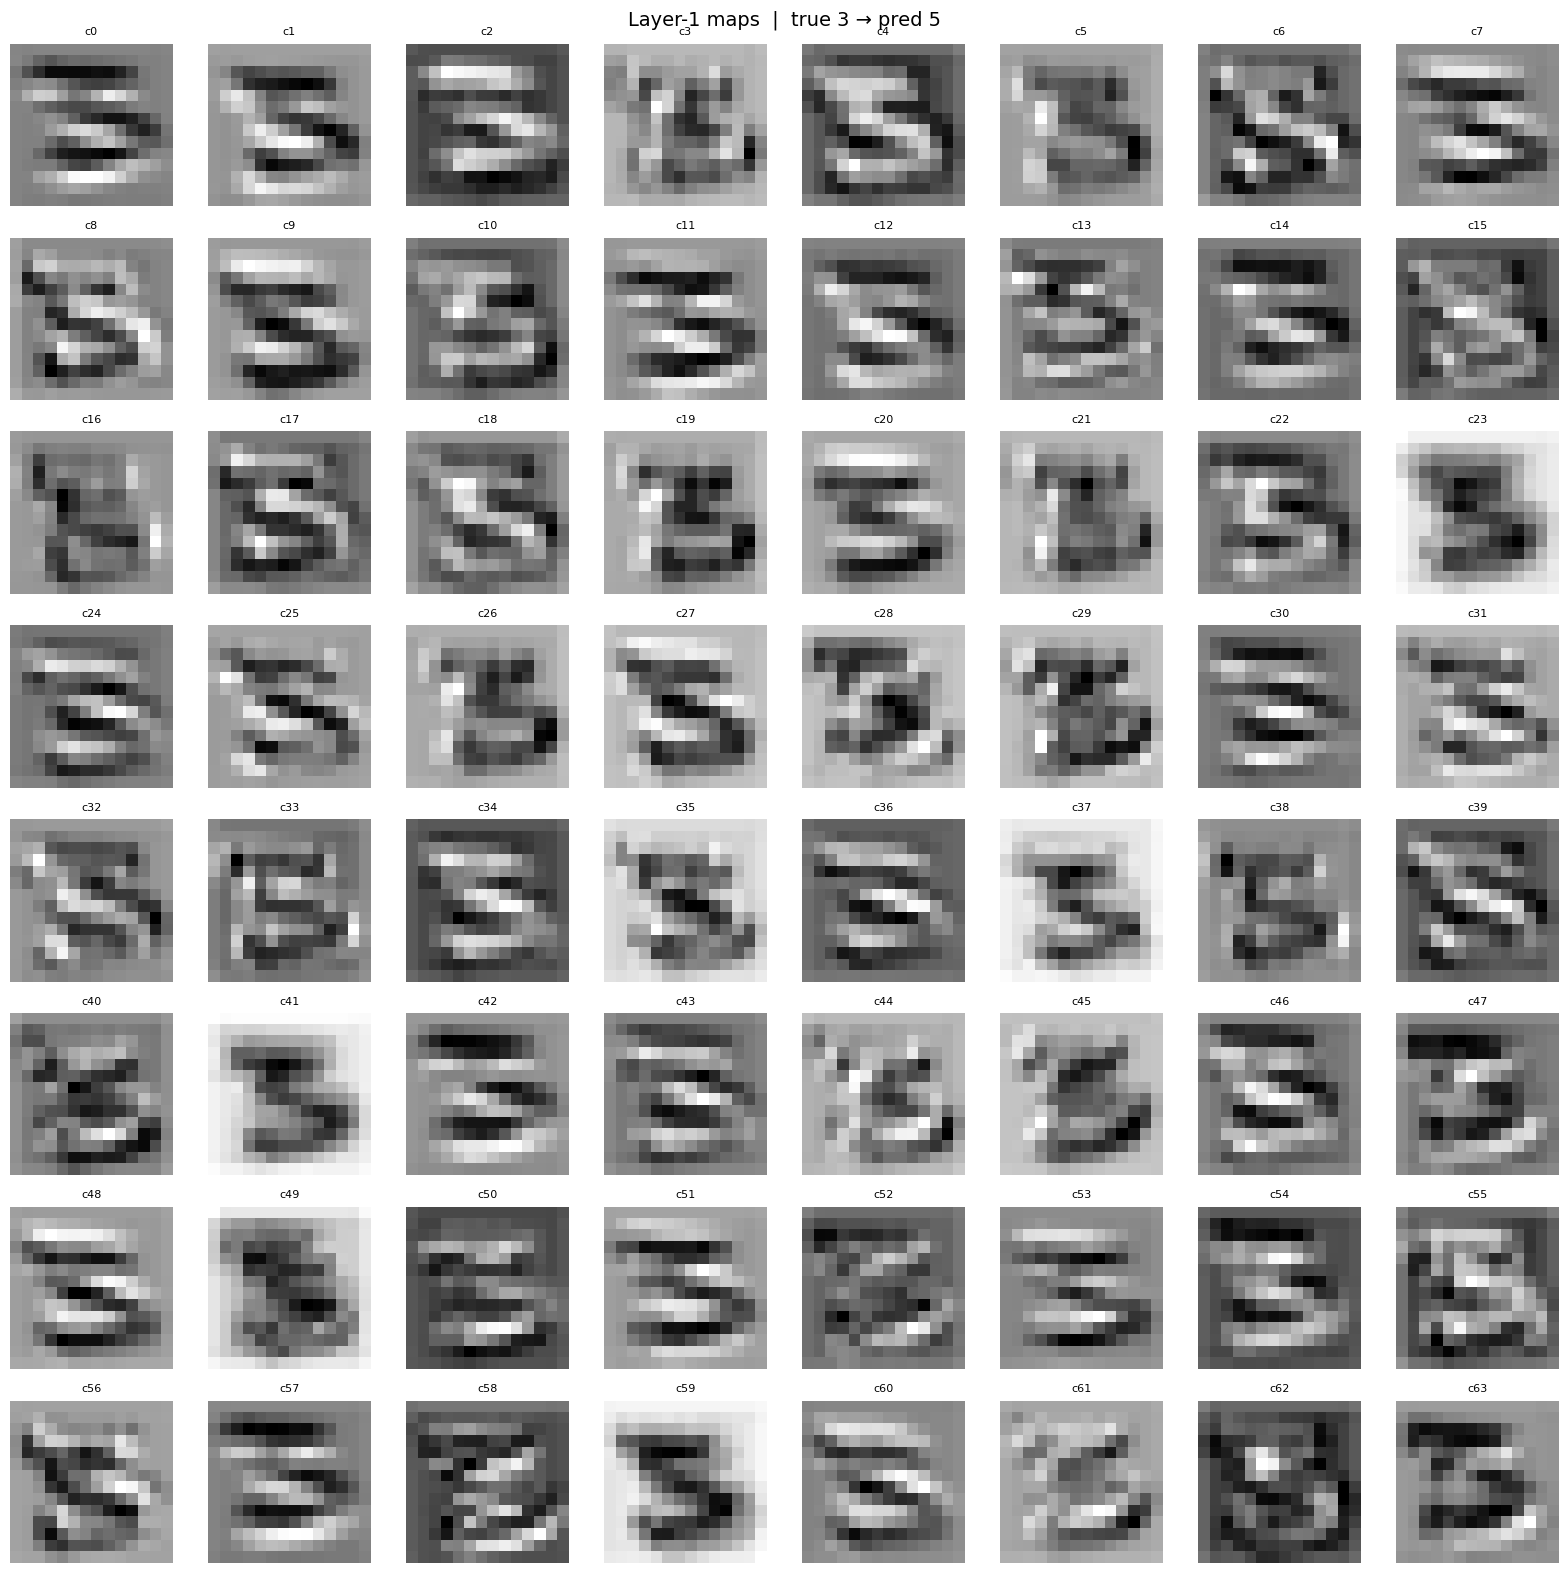

In [44]:
# --- gather mistakes (swap `model` for `fnn` to inspect the FNN) -------------
mis = find_misclassified(cnn, test_loader, max_items=25)

img, pred, true = mis[4]       # img is [C,H,W]  i.e. [1,28,28]

# 2️⃣ wrap it in a batch dimension so the model expects [1,C,H,W]
img_tensor = img.unsqueeze(0)  # shape  [1,1,28,28]

print(f"Using mis-classified digit: true={true}, pred={pred}")

# 3️⃣ visualise feature maps (layer 0 = first conv, 1 = second, …)
show_feature_maps(cnn,
                      img_tensor,
                      layer_num=1,          # choose the layer
                      title=f"Layer-1 maps  |  true {true} → pred {pred}")

In [27]:
def find_correctly_classified(model, loader, max_items=25):
    """
    Return a list of (img_tensor, pred_label, true_label) triples
    that the model classifies *correctly*.

    Parameters
    ----------
    model : nn.Module           (e.g. cnn)
    loader : DataLoader         (e.g. test_loader)
    max_items : int | None      stop after this many matches

    Notes
    -----
    • img_tensor is [C, H, W] — exactly what came out of the DataLoader
    • Call .unsqueeze(0) before feeding it back to the network.
    """
    model.eval()
    hits = []
    with torch.no_grad():
        for x, y in loader:                   # x: [B,C,H,W]
            x, y = x.to(next(model.parameters()).device), y.to(next(model.parameters()).device)
            preds = model(x).argmax(1)       # [B]
            mask  = preds.eq(y)              # correct predictions
            for img, p, t in zip(x[mask].cpu(), preds[mask].cpu(), y[mask].cpu()):
                hits.append((img, int(p), int(t)))
                if max_items and len(hits) == max_items:
                    return hits
    return hits


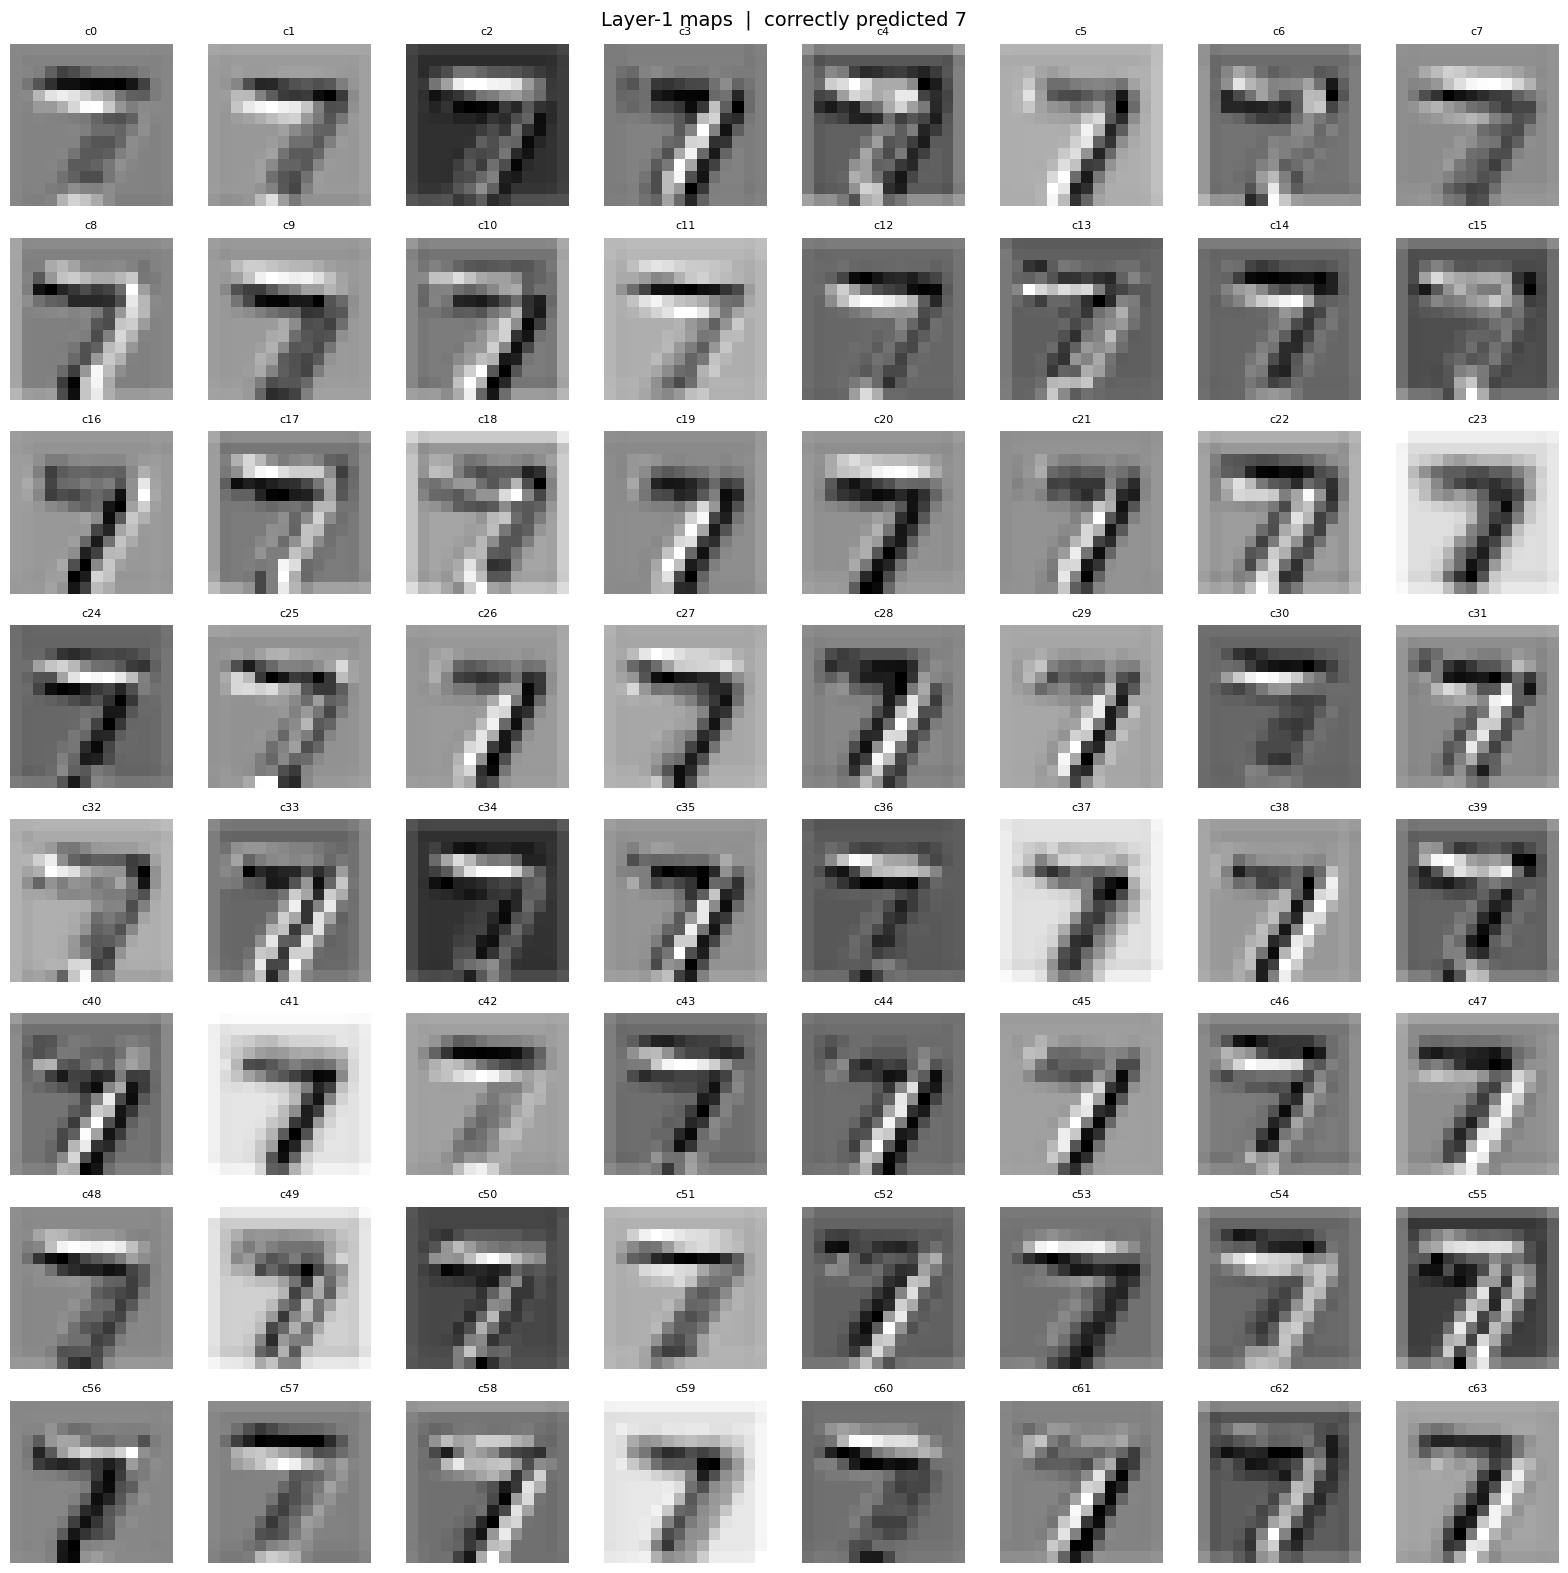

In [28]:
# -- grab one correct example -----------------------------------
correct = find_correctly_classified(cnn, test_loader, max_items=1)
if correct:
    img_c, pred_c, true_c = correct[0]
    img_c_tensor = img_c.unsqueeze(0)      # [1,1,28,28]

    # visualise layer-1 feature maps for the correctly recognised digit
    show_feature_maps(cnn,
                      img_c_tensor,
                      layer_num=1,
                      title=f"Layer-1 maps  |  correctly predicted {pred_c}")
else:
    print("Strangely, no correct predictions found!")
